

# Titanic Competition


# 

In [13]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

#Split values based on the two CSVs
training = pd.read_csv("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv")
testing = pd.read_csv("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv")
#create boolean column to break training and testing data. but we will keep them combined for imputation
training['training_data'] = True
testing['training_data'] = False
data = pd.concat([training, testing], axis=0).reset_index(drop=True)


In [14]:
data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,training_data
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,False
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,False
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,False
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,False
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,NaN,2668,False


In [15]:
def categorize_values(value, column):
    """
    Apply categories based on percentiles of data
    """
    if value <= data[[column]].describe().ix['25%'].values: #7.91
        category = 0
    elif value >= data[[column]].describe().ix['75%'].values: #31
        category = 2
    else:
        category=1
    return category

def survival_ratios(data_series, column_name, df):
    """
    Return pivot ratios of the data and survival rates
    """
    data_values = pd.concat([df[['Survived','PassengerId']], 
                           pd.DataFrame(data=data_series, columns=column_name)], axis=1 )
    pvt_data = pd.pivot_table(data=data_values, index=['Survived'],
                               columns=column_name, values =['PassengerId'], aggfunc='count')
    return pvt_data.apply(lambda x: x / (x.max() + x.min()))

def title_extract(name):
    title = name.split(',')[1].split('.')[0].strip()
    if title in title_map: title = title_map[title]
    return title

In [16]:
survival_ratios(data[['Age']].values, ['Age'])

TypeError: survival_ratios() takes exactly 3 arguments (2 given)

#-------------------------------------------------------------------
# pipelines and scalars
#-------------------------------------------------------------------

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.decomposition import PCA, RandomizedPCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC


In [18]:
#from sklearn.grid_search.RandomizedSearchCV
#from sklearn.grid_search.ParameterGrid
#from sklearn.grid_search.ParameterSampler

In [19]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,training_data
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,True
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,True
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,True
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,True
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,True


###Feature Engineering

In [20]:
#data['child'] = (data.Age.dropna() <= 18)*1

data['expensive_coach_woman'] = ((data.Sex == 'female') & (data.Pclass==3) & (data.Fare >= 20)) * 1
# based on looking at the values there are a few that appear very infrequently, we will map them to more useful values
title_map = {'Capt': 'Sir', 'Don':'Sir', 'Major':'Sir', 'Sir':'Sir', 'Col':'Sir', 'Mlle':'Sir', 'Jonkheer':'Sir',
             'Mme': 'Lady', 'Lady':'Lady', 'the Countess':'Lady', 'Ms': 'Miss'}

data['Title'] = data.Name.apply(lambda x: title_extract(x))
data['Surname'] = data.Name.apply(lambda x: x.split(',')[0])
data['Family_size'] = data.SibSp + data.Parch + 1
data['FamilyID'] = (data.Family_size.astype(str) + data.Surname) * ((data.Family_size >= 2) * 1)
data['FamilyID'] = data['FamilyID'].apply(lambda x: 'small' if x == '' else x)
data['TicketCategory'] = data['Fare'].apply(lambda x: categorize_values(x, 'Fare'))
data['AgeCategory'] = data['Fare'].apply(lambda x: categorize_values(x, 'Age'))
data['FamilyCategory'] = data['Family_size'].apply(lambda x: categorize_values(x, 'Family_size'))

In [23]:
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,training_data,expensive_coach_woman,Title,Surname,Family_size,FamilyID,TicketCategory,AgeCategory,FamilyCategory
0,22,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171,True,0,Mr,Braund,2,2Braund,0,0,2
1,38,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599,True,0,Mrs,Cumings,2,2Cumings,2,2,2
2,26,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282,True,0,Miss,Heikkinen,1,small,1,0,0
3,35,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803,True,0,Mrs,Futrelle,2,2Futrelle,2,2,2
4,35,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450,True,0,Mr,Allen,1,small,1,0,0


In [35]:
features[features.training_data].drop(['Survived', 'training_data'], 1)

,expensive_coach_woman,Pclass,TicketCategory,FamilyCategory,Sex_female,Miss,Mr,Mrs,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,2,0,0,1,0,0,0,1
1,0,1,2,2,1,0,0,1,1,0,0
2,0,3,1,0,1,1,0,0,0,0,1
3,0,1,2,2,1,0,0,1,0,0,1
4,0,3,1,0,0,0,1,0,0,0,1
5,0,3,1,0,0,0,1,0,0,1,0
6,0,1,2,0,0,0,1,0,0,0,1
7,0,3,1,2,0,NaN,NaN,NaN,0,0,1
8,0,3,1,2,1,0,0,1,0,0,1
9,0,2,1,2,1,0,0,1,1,0,0


In [48]:
#'Fare', 'Age',
features = pd.concat([data[['expensive_coach_woman', 'Pclass', 'TicketCategory', 'FamilyCategory']],
                      pd.get_dummies(data['Sex'], prefix='Sex'),
                      #looks like these are the only useful
                      pd.get_dummies(data[data['Title'].isin(['Mr','Miss','Mrs'])]['Title']), 
                      pd.get_dummies(data['Embarked'], prefix='Embarked'),
                     data[['training_data','Survived', 'PassengerId']], ], axis=1)
# because the data is only male or femail we will drop the 'Sex_male' column as it is duplicated
features = features.drop('Sex_male', 1)

# We will try to loop through the different classes and sex to apply the median age
#now we loop through the sex and cabin class values and apply the median age valuesto the groups
for sex in xrange(0,2):
    for cabin in xrange(0,4):
        median_age = data[(features.Pclass == cabin) & (features.Sex_female == sex)].dropna().median()
        features[(features.Pclass == cabin) & (features.Sex_female == sex)
                    ] = features[(features.Pclass == cabin) & (features.Sex_female == sex) ].fillna(median_age)

target = features[features.training_data].Survived
features = features.fillna(0)
training_features = features[features.training_data].drop(['Survived','training_data','PassengerId'],  1)
kaggle_data = features[~features.training_data].drop(['Survived','training_data'], 1)

#features = features.fillna(-1)

# Because of the following bug we cannot use NaN as the missing
# value marker, use a negative value as marker instead:
# https://github.com/scikit-learn/scikit-learn/issues/3044
training_features.head(5)

,expensive_coach_woman,Pclass,TicketCategory,FamilyCategory,Sex_female,Miss,Mr,Mrs,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,2,0,0,1,0,0,0,1
1,0,1,2,2,1,0,0,1,1,0,0
2,0,3,1,0,1,1,0,0,0,0,1
3,0,1,2,2,1,0,0,1,0,0,1
4,0,3,1,0,0,0,1,0,0,0,1


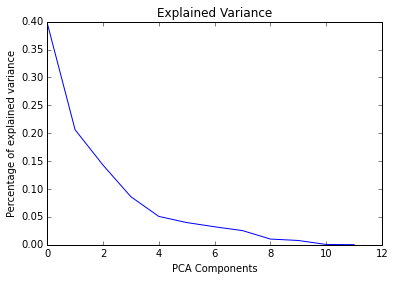

In [72]:
from sklearn.decomposition import PCA, RandomizedPCA

pca = RandomizedPCA()
#print pca.explained_variance_ratio_
pca.fit(pd.concat([pd.DataFrame(target), training_features], axis=1))

pca_big = PCA().fit(training_features[['Sex_female','TicketCategory']], target)
plt.title("Explained Variance")
plt.ylabel("Percentage of explained variance")
plt.xlabel("PCA Components")
plt.plot(pca.explained_variance_ratio_);

In [69]:
# Minimum percentage of variance we want to be described by the resulting transformed components
variance_pct = .99
 
# Create PCA object
pca = PCA(n_components=variance_pct)
 
# Transform the initial features
X_transformed = pca.fit_transform(training_features.values, target)
 
# Create a data frame from the PCA'd data
pcaDataFrame = pd.DataFrame(X_transformed)
 
print pcaDataFrame.shape[1], " components describe ", str(variance_pct)[1:], "% of the variance"

8  components describe  .99 % of the variance


In [40]:
imputer = Imputer(strategy='median', missing_values=-1)
scalar = StandardScaler()
pca = PCA()
classifiers = [RandomForestClassifier(), GradientBoostingClassifier(), 
               ExtraTreesClassifier(), LogisticRegression(), DecisionTreeClassifier(),
               KNeighborsClassifier(), SVC(), LinearSVC(), GaussianNB()]

print '\n'
for classifier in classifiers:
    pipeline = Pipeline([
        #('scl', scalar),
        ('imp', imputer),
        ('clf', classifier),
    ])
    #scores = cross_val_score(pipeline, features.values, target, cv=5, scoring='accuracy')
    scores = cross_val_score(pipeline, training_features, target, cv=10, scoring='accuracy')
    print str(classifier)
    print('min -', scores.min(), 'mean -', scores.mean(), 'max -', scores.max())
    print '\n\n'



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
('min -', 0.7078651685393258, 'mean -', 0.80818579048916139, 'max -', 0.8539325842696629)



GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
('min -', 0.7415730337078652, 'mean -', 0.81264243559187377, 'max -', 0.8764044943820225)



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_

## Gradient Boosting

In [42]:
imputer = Imputer(strategy='median', missing_values=-1)
scalar = StandardScaler()
pca = PCA()

classifier = GradientBoostingClassifier(n_estimators=100, subsample=.8)

params = {
    #'pca__n_components': np.arange(2,features.shape[1]+1).tolist() ,
    'clf__learning_rate': [0.1, 0.15, 0.2],
    'clf__max_features': [0.76, 0.77, 0.78],
    'clf__max_depth': [3.6, 3.63],
}

pipeline = Pipeline([
    #('scl', scalar),
    ('imp', imputer),
    # ('pca', pca),
    ('clf', classifier),
])

grid_search = GridSearchCV(pipeline, params, cv=10, scoring='accuracy')
grid_search.fit(training_features.values, target)
print grid_search.best_score_
print grid_search.best_params_
# with pca
# 0.866883208974
# {'clf__max_features': 0.77, 'clf__max_depth': 3.63, 'clf__learning_rate': 0.1, 'pca__n_components': 3}
# without pca without scalar
# 0.87819667245
# {'clf__max_features': 0.77, 'clf__max_depth': 3.63, 'clf__learning_rate': 0.1}
# without pca with scalar
# 0.878755362749
# {'clf__max_features': 0.76, 'clf__max_depth': 3.63, 'clf__learning_rate': 0.1}

0.871084824548
{'clf__max_features': 0.78, 'clf__max_depth': 3.63, 'clf__learning_rate': 0.1}


## Random Forest

In [43]:
imputer = Imputer(strategy='median', missing_values=-1)
scalar = StandardScaler()
pca = PCA()

classifier = RandomForestClassifier(n_estimators=100)

params = {
   # 'pca__n_components': np.arange(2,features.shape[1]+1).tolist() ,
    'clf__criterion':['gini','entropy'],
    'clf__max_features': [0.75, 0.8, 0.9],
    'clf__max_depth': [3.75, 3.9, 4, 4.1],
    'clf__min_samples_split': [2, 10, 50],
}

pipeline = Pipeline([
    #('scl', scalar),
    ('imp', imputer),
    #('pca', pca),
    ('clf', classifier),
])

grid_search2 = GridSearchCV(pipeline, params, cv=10, scoring='accuracy')
grid_search2.fit(training_features.values, target)
print grid_search2.best_score_
print grid_search2.best_params_
# with pca
# 0.86815556909
# {'pca__n_components': 15, 'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__max_features': 0.8, 'clf__min_samples_split': 50}
# without pca, with scalar
# 0.884116233304
# {'clf__criterion': 'entropy', 'clf__max_depth': 4.1, 'clf__max_features': 0.9, 'clf__min_samples_split': 2}
# without pca, without scalar
# 0.882875577875
# {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__max_features': 0.9, 'clf__min_samples_split': 2}

0.822671156004
{'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__max_features': 0.9, 'clf__min_samples_split': 2}


In [28]:
imputer = Imputer(strategy='median', missing_values=-1)
scalar = StandardScaler()
pca = PCA()

classifier = LinearSVC()

params = {
    'pca__n_components': np.arange(2,features.shape[1]+1).tolist() ,
    #'clf__penalty':['l2','l1'],
    #'clf__loss': ['hinge','squared_hinge'],
    'clf__class_weight': [None, 'auto'],
    'clf__C': [1.0, 10.0, 100.0, 1000.0],
}

pipeline = Pipeline([
    ('scl', scalar),
    ('imp', imputer),
    ('pca', pca),
    ('clf', classifier),
])

grid_search = GridSearchCV(pipeline, params, cv=10, scoring='roc_auc')
grid_search.fit(features.values, target)
print grid_search.best_score_
print grid_search.best_params_

0.867379761709
{'pca__n_components': 15, 'clf__C': 1.0, 'clf__class_weight': None}


# Predicting Test Values for Kaggle Submission

In [50]:
kaggle_data

,expensive_coach_woman,Pclass,TicketCategory,FamilyCategory,Sex_female,Miss,Mr,Mrs,Embarked_C,Embarked_Q,Embarked_S,PassengerId
891,0,3,0,0,0,0,1,0,0,1,0,892
892,0,3,0,2,1,0,0,1,0,0,1,893
893,0,2,1,0,0,0,1,0,0,1,0,894
894,0,3,1,0,0,0,1,0,0,0,1,895
895,0,3,1,2,1,0,0,1,0,0,1,896
896,0,3,1,0,0,0,1,0,0,0,1,897
897,0,3,0,0,1,1,0,0,0,1,0,898
898,0,2,1,2,0,0,1,0,0,0,1,899
899,0,3,0,0,1,0,0,1,1,0,0,900
900,0,3,1,2,0,0,1,0,0,0,1,901


In [67]:
pred = grid_search2.predict(kaggle_data.drop('PassengerId',1).values)

gb_pred = pd.concat([kaggle_data['PassengerId'].reset_index(drop=True), 
                     pd.DataFrame(data=pred, columns=['Survived'])], axis=1)
gb_pred.to_csv('GB_classifier_20150709_v4.csv', index=False)

In [68]:
gb_pred

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [74]:
rf = RandomForestClassifier()
rf.fit(training_features, target)
pred = rf.predict(kaggle_data.drop('PassengerId',1).values)

rf_pred = pd.concat([kaggle_data['PassengerId'].reset_index(drop=True), 
                     pd.DataFrame(data=pred, columns=['Survived'])], axis=1)
rf_pred.to_csv('Titanic_classifier_20150709_v5.csv', index=False)

# Found random solution online

In [ ]:
import numpy as np

import pandas as pd

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, Imputer
from patsy import dmatrices, dmatrix

#Print you can execute arbitrary python code
#Split values based on the two CSVs
df_train = pd.read_csv("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv", 
                       dtype={"Age": np.float64} )
df_test = pd.read_csv("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/test.csv", 
                    dtype={"Age": np.float64} )



In [ ]:
# Drop NaNs
df_train.dropna(subset=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], inplace=True)

print("\n\nSummary statistics of training data")
print(df_train.describe())

# Age imputation
df_train.loc[df_train['Age'].isnull(), 'Age'] = np.nanmedian(df_train['Age'])
df_test.loc[df_test['Age'].isnull(), 'Age'] = np.nanmedian(df_test['Age'])

# Training/testing array creation
y_train, X_train = dmatrices('Survived ~ Age + Sex + Pclass + SibSp + Parch + Embarked', df_train)
X_test = dmatrix('Age + Sex + Pclass + SibSp + Parch + Embarked', df_test)

# Creating processing pipelines with preprocessing. Hyperparameters selected using cross validation
steps1 = [('poly_features', PolynomialFeatures(3, interaction_only=True)),
          ('logistic', LogisticRegression(C=5555., max_iter=16, penalty='l2'))]
steps2 = [('rforest', RandomForestClassifier(min_samples_split=15, n_estimators=73, criterion='entropy'))]
pipeline1 = Pipeline(steps=steps1)
pipeline2 = Pipeline(steps=steps2)

# Logistic model with cubic features
pipeline1.fit(X_train, y_train.ravel())
print('Accuracy (Logistic Regression-Poly Features (cubic)): {:.4f}'.format(pipeline1.score(X_train, y_train.ravel())))

# Random forest with calibration
pipeline2.fit(X_train[:600], y_train[:600].ravel())
calibratedpipe2 = CalibratedClassifierCV(pipeline2, cv=3, method='sigmoid')
calibratedpipe2.fit(X_train[600:], y_train[600:].ravel())
print('Accuracy (Random Forest - Calibration): {:.4f}'.format(calibratedpipe2.score(X_train, y_train.ravel())))

# Create the output dataframe
output = pd.DataFrame(columns=['PassengerId', 'Survived'])
output['PassengerId'] = df_test['PassengerId']

# Predict the survivors and output csv
output['Survived'] = pipeline1.predict(X_test).astype(int)
output.to_csv('output.csv', index=False)

In [ ]:
# Drop NaNs
df_train.dropna(subset=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], inplace=True)

print("\n\nSummary statistics of training data")
print(df_train.describe())

# Age imputation
df_train.loc[df_train['Age'].isnull(), 'Age'] = np.nanmedian(df_train['Age'])
df_test.loc[df_test['Age'].isnull(), 'Age'] = np.nanmedian(df_test['Age'])

# Training/testing array creation
y_train, X_train = dmatrices('Survived ~ Age + Sex + Pclass + SibSp + Parch + Embarked', df_train)
X_test = dmatrix('Age + Sex + Pclass + SibSp + Parch + Embarked', df_test)

# Creating processing pipelines with preprocessing. Hyperparameters selected using cross validation
steps1 = [('poly_features', PolynomialFeatures(3, interaction_only=True)),
          ('logistic', LogisticRegression(C=5555., max_iter=16, penalty='l2'))]
steps2 = [('rforest', RandomForestClassifier(min_samples_split=15, n_estimators=73, criterion='entropy'))]
pipeline1 = Pipeline(steps=steps1)
pipeline2 = Pipeline(steps=steps2)

# Logistic model with cubic features
pipeline1.fit(X_train, y_train.ravel())
print('Accuracy (Logistic Regression-Poly Features (cubic)): {:.4f}'.format(pipeline1.score(X_train, y_train.ravel())))

# Random forest with calibration
pipeline2.fit(X_train[:600], y_train[:600].ravel())
calibratedpipe2 = CalibratedClassifierCV(pipeline2, cv=3, method='sigmoid')
calibratedpipe2.fit(X_train[600:], y_train[600:].ravel())
print('Accuracy (Random Forest - Calibration): {:.4f}'.format(calibratedpipe2.score(X_train, y_train.ravel())))

# Create the output dataframe
output = pd.DataFrame(columns=['PassengerId', 'Survived'])
output['PassengerId'] = df_test['PassengerId']

# Predict the survivors and output csv
output['Survived'] = pipeline1.predict(X_test).astype(int)
output.to_csv('output.csv', index=False)